In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_data.csv', 'train_data.csv']


In [16]:
data = pd.read_csv('../input/train_data.csv', usecols=['message', 'food','recharge','support','reminders','travel','nearby','movies','casual','other'
])

In [17]:
categories=['food','recharge','support','reminders','travel','nearby','movies','casual','other']

In [19]:
len(data['food'])

40659

In [20]:
for i in categories:
    for x in range(len(data[i])):
        if data.iloc[x][i]=='T':
            data.iloc[x][i]=1
        else:
            data.iloc[x][i]=0

In [22]:
data.iloc[20019]['food']

0

In [23]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"{([^}]*})","",text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [24]:
data['message'] = data['message'].map(lambda com : clean_text(com))

In [25]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['message'].values)
sequences = tokenizer.texts_to_sequences(data['message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 17443 unique tokens.


In [26]:
labels=data.drop(['message'], axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [28]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0


In [29]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((30494, 130), (30494, 9), (10165, 130), (10165, 9))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 585       
Total params: 1,073,993
Trainable params: 1,073,993
Non-trainable params: 0
_________________________________________________________________
None
Train on 24395 samples, validate on 6099 samples
Epoch 1/10
24395/24395 [==============================] - 26s 1ms/step - loss: 2.3765 - acc: 0.2744 - val_loss: 2.1963 - val_acc: 0.3179
Epoch 2/10
24395/243

In [30]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10165/10165 [==============================] - 26s 3ms/step
Test set
  Loss: 1.078
  Accuracy: 0.771


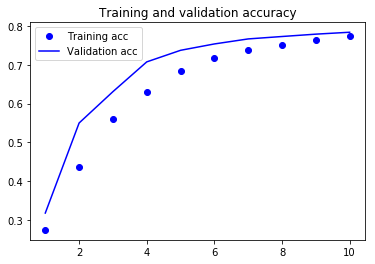

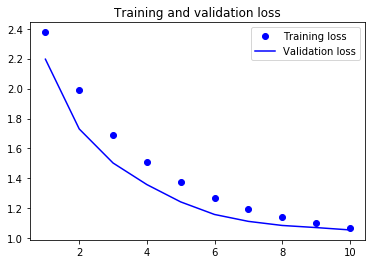

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
txt = ["hey i need tickets for majnu"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['food','recharge','support','reminders','travel','nearby','movies','casual','other']
print(pred, labels[np.argmax(pred)])

[[0.05091383 0.01843342 0.01844317 0.00500459 0.48187503 0.01501272
  0.40223116 0.00355207 0.004534  ]] travel
